<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>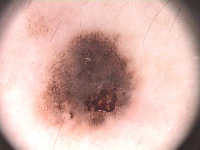</td><td>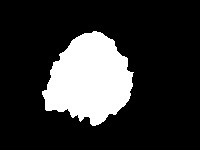</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

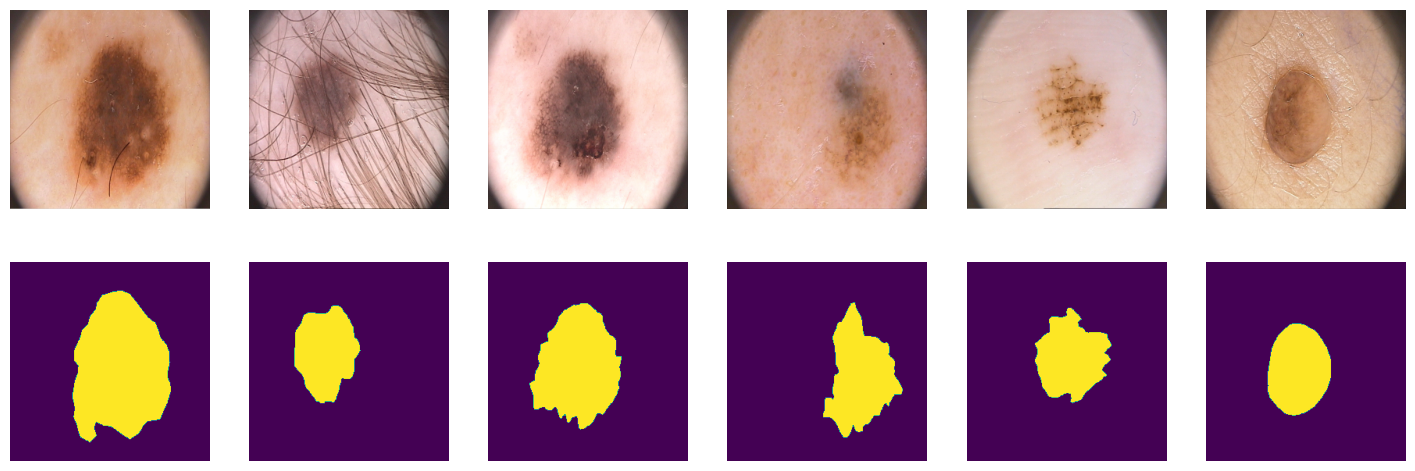

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [110, 155])
print(len(tr), len(val), len(ts))

110 45 45


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 8
train_dataloader = DataLoader(
    list(zip(np.rollaxis(X[tr], 3, 1),
    Y[tr, np.newaxis])),
    batch_size=batch_size,
    shuffle=True
)
valid_dataloader = DataLoader(
    list(zip(np.rollaxis(X[val], 3, 1),
    Y[val, np.newaxis])),
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    list(zip(np.rollaxis(X[ts], 3, 1),
    Y[ts, np.newaxis])),
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** 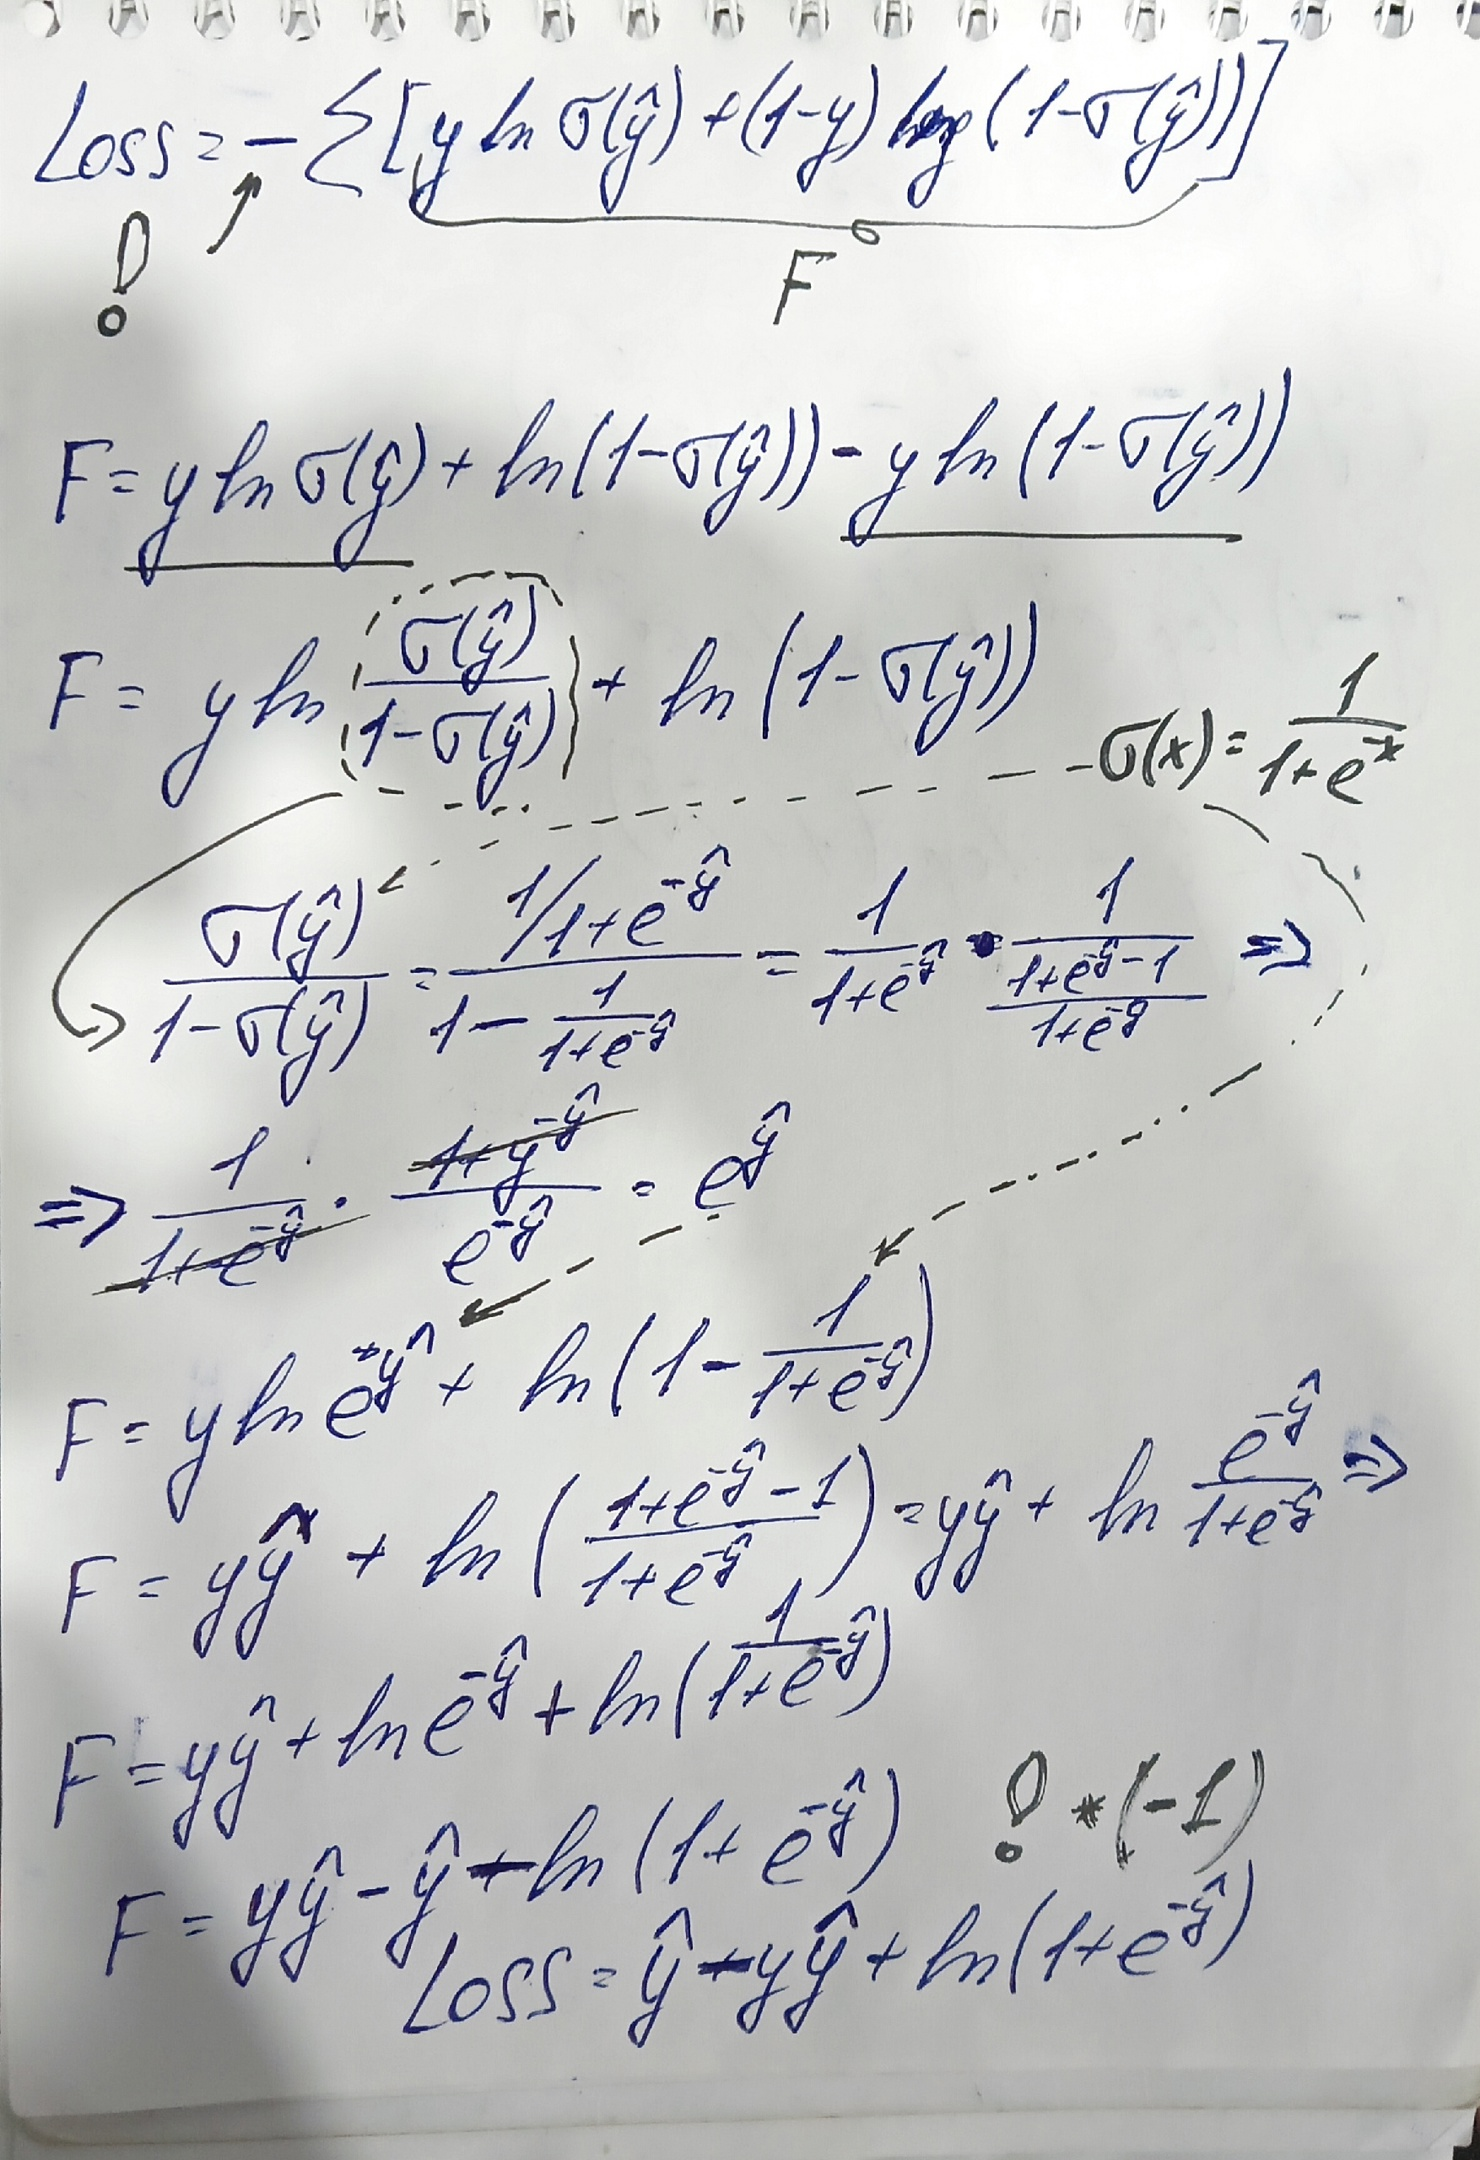

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  losses = -(y_real * torch.log(F.sigmoid(y_pred)) + (1-y_real)*torch.log(1-F.sigmoid(y_pred)))
  return losses.sum()


def bce_true(y_pred, y_real):
  losses = y_pred - y_pred * y_real + torch.log(1+torch.exp(-y_pred))
  return losses.sum()

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.8911004066467285
BCE loss честно посчитанный = 4.89109992980957
BCE loss from torch bce_torch = 4.89109992980957
BCE loss from torch with logits bce_torch = 4.89109992980957


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 12.994046211242676
BCE loss честно посчитанный = 12.994047164916992
BCE loss from torch bce_torch = 12.994046211242676
BCE loss from torch with logits bce_torch = 12.994047164916992


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
path_to_dummy_samples = './for_assets'
dummpy_sample = {
    'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
    'labels': torch.load(f'{path_to_dummy_samples}/labels.pt'),
}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

C:\Users\LicrimoVor\AppData\Local\Temp\ipykernel_10456\2357153540.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  'logits': torch.load(f'{path_to_dummy_samples}/logits.p

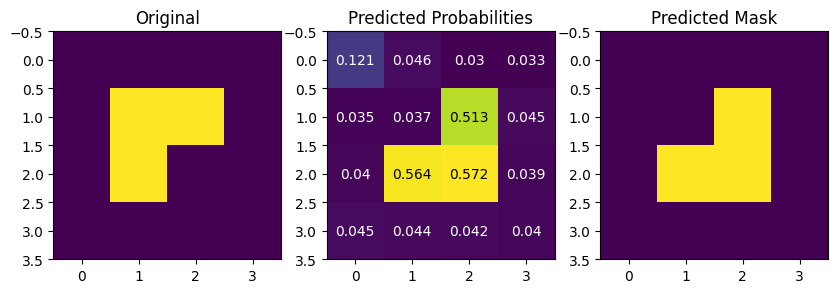

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

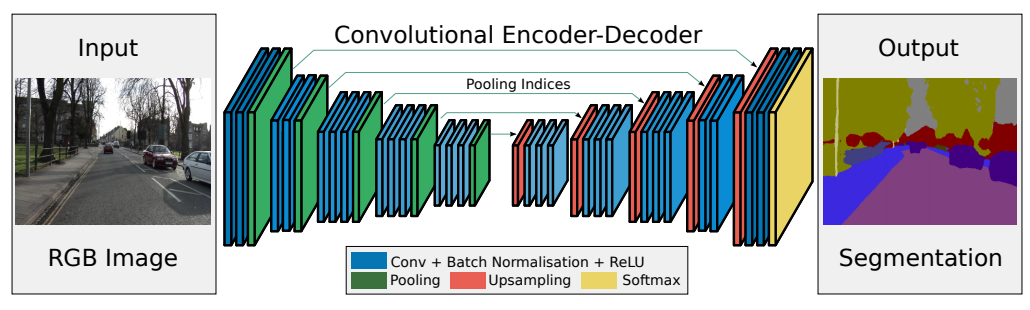

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, count_conv: int):
        super().__init__()

        self.__count_conv = count_conv
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        for i in range(count_conv-1):
            conv = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
            setattr(self, f'conv_{i+2}', conv)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        out = x
        for i in range(self.__count_conv):
            out = getattr(self, f'conv_{i+1}')(out)
        out, self.pool_indice = self.max_pool(out)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, count_conv: int):
        super().__init__()

        self.__count_conv = count_conv
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        i = 0
        for _ in range(count_conv-1):
            i += 1
            conv = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
            )
            setattr(self, f'conv_{i}', conv)

        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        setattr(self, f'conv_{i+1}', conv)

    def forward(self, x, pool_indice):
        out = self.max_unpool(x, pool_indice)
        for i in range(self.__count_conv):
            out = getattr(self, f'conv_{i+1}')(out)

        return out


class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.encoder = nn.Sequential(
            EncoderBlock(in_channels, 64, 2),
            EncoderBlock(64, 128, 2),
            EncoderBlock(128, 256, 3),
            EncoderBlock(256, 512, 3),
        )

        self.bottleneck = nn.Conv2d(512, 512, kernel_size=1)

        self.decoder = nn.Sequential(
            DecoderBlock(512, 256, 3),
            DecoderBlock(256, 128, 3),
            DecoderBlock(128, 64, 2),
            DecoderBlock(64, out_channels, 2),
        )


    def forward(self, x):
        out = self.encoder(x)
        out = self.bottleneck(out)
        for i, block in enumerate(self.decoder):
            pool_indice = self.encoder[-(i+1)].pool_indice
            out = block(out, pool_indice)

        return out

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [ ]:
def save(
    model: nn.Module,
    history: dict[str, list[float]],
    optimizer: optim.Optimizer,
    loss_fn: nn.modules.loss._WeightedLoss,
    epoch: int,
    path: str,
):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_fn,
        'history': history,
        }, path
    )


def load(model: nn.Module, optimizer: optim.Optimizer=None, path:str=''):
    checkpoint = torch.load(path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    history = checkpoint['history']

    return model, optimizer, epoch, loss, history


In [ ]:
from tqdm import tqdm


def train(
    model: nn.Module,
    dl_train: DataLoader,
    dl_valid: DataLoader,
    loss_fn: nn.modules.loss._WeightedLoss,
    optimizer: optim.Optimizer,
    epoch: int,
    is_logit: bool=False,
    scheduler=None
):
  history = {
    'train': [],
    'valid': []
  }

  for i in range(epoch):
    print(f"Epoch: {i+1}")

    model.train()
    train_metric = 0
    for input, output in tqdm(dl_train, desc='train'):
      input, output = input.to(device), output.to(device)
      optimizer.zero_grad()
      predict = model(input)

      if not is_logit:
        loss = loss_fn(torch.sigmoid(predict), output)
      else:
        loss = loss_fn(predict, output)

      loss.backward()
      optimizer.step()

      if scheduler is not None:
        scheduler.step()

      train_metric += iou_score(predict, output).cpu().item()

    train_metric /= len(dl_train)
    history['train'].append(train_metric)

    model.eval()
    valid_metric = 0
    for input, output in tqdm(dl_valid, desc='valid'):
      input, output = input.to(device), output.to(device)
      with torch.no_grad():
        predict = model(input)

      valid_metric += iou_score(predict, output).cpu().item()

    valid_metric /= len(dl_valid)
    history['valid'].append(valid_metric)

    print(f'IoU train: {train_metric}')
    print(f'IoU valid: {valid_metric}')

  return history

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
EPOCH_COUNT = 15
STEP_SIZE = 10
segnet_model = SegNet().to(device)
optimizer = optim.Adam(segnet_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
history_segnet_bce = train(segnet_model, train_dataloader, valid_dataloader, bce_true, optimizer, EPOCH_COUNT, is_logit=True,)

Epoch: 1


valid: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


IoU train: 0.2594547229153769
IoU valid: 0.0
Epoch: 2


valid: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


IoU train: 0.556519186922482
IoU valid: 0.297241035848856
Epoch: 3


valid: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


IoU train: 0.6439138948917389
IoU valid: 0.43489527702331543
Epoch: 4


valid: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


IoU train: 0.6584610726152148
IoU valid: 0.2596527909239133
Epoch: 5


valid: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


IoU train: 0.6703990910734449
IoU valid: 0.6629173854986826
Epoch: 6


valid: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


IoU train: 0.7068470631326947
IoU valid: 0.6833047668139139
Epoch: 7


valid: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


IoU train: 0.68165294613157
IoU valid: 0.7050480445226034
Epoch: 8


valid: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


IoU train: 0.6901694898094449
IoU valid: 0.6372545808553696
Epoch: 9


valid: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


IoU train: 0.7258130290678569
IoU valid: 0.661142627398173
Epoch: 10


valid: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


IoU train: 0.7240632602146694
IoU valid: 0.7432363629341125
Epoch: 11


valid: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


IoU train: 0.7117226379258292
IoU valid: 0.6838692128658295
Epoch: 12


valid: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


IoU train: 0.730411063347544
IoU valid: 0.5479152798652649
Epoch: 13


valid: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


IoU train: 0.7487923204898834
IoU valid: 0.7227303882439932
Epoch: 14


valid: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


IoU train: 0.7191354376929147
IoU valid: 0.712048610051473
Epoch: 15


valid: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]

IoU train: 0.7212126553058624
IoU valid: 0.7905922929445902


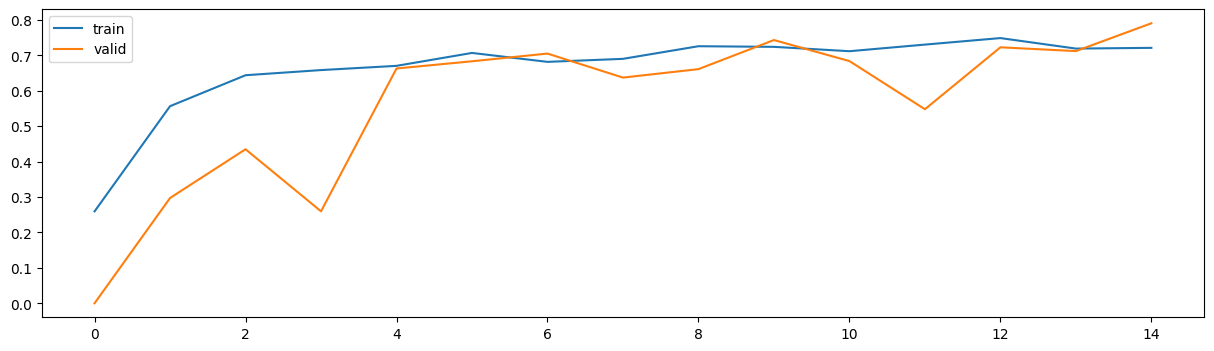

In [ ]:
plt.plot(history_segnet_bce['train'])
plt.plot(history_segnet_bce['valid'])
plt.legend(('train', 'valid'))

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(
    model: nn.Module,
    dl_test: DataLoader,
):
  model.eval()
  test_metric = 0
  for input, output in tqdm(dl_test, desc='test'):
    input, output = input.to(device), output.to(device)
    predict = model(input)
    test_metric += iou_score(torch.sigmoid(predict), output).cpu().item()

  test_metric /= len(dl_test)

  return test_metric

In [ ]:
test(segnet_model, test_dataloader)

test: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


0.7345570921897888

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''Это именно метрика, не лосс.'''
    preds = (torch.sigmoid(logits) > threshold).type(torch.uint8)
    TP = (preds & labels.type(torch.uint8)).sum()
    FP = ((preds - labels) > 0).sum()
    FN = ((labels - preds) > 0).sum()
    e = 1e-8

    score = (2 * TP + e) / (2 * TP + FP + FN + e)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)), dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

(tensor(0.6667), tensor(0.6667))

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    '''Это лосс.'''
    preds = torch.sigmoid(logits)
    inv_labels = (labels == 0).type(torch.uint8)
    TP = (preds * labels).sum()
    FP = (preds * inv_labels).sum()
    FN = (labels - preds * labels).sum()
    e = 1e-8

    score = (2 * TP + e) / (2 * TP + FP + FN + e)
    return 1 - score

dice = dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

Проверка на корректность:

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

d:\Code\Python\ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    preds = torch.sigmoid(y_pred) + eps/2
    p_t = preds * y_real + (1-preds) * (1-y_real)
    loss = - torch.sum((1-p_t) ** gamma * (y_real*torch.log(preds) + (1-y_real)*torch.log(1-preds)))

    return loss

focal = focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
def boundary_loss(preds: torch.Tensor, labels: torch.Tensor):
    multipled = torch.einsum("bkwh,bkwh->bkwh", preds, labels)
    loss = multipled.mean()
    return loss

boundary = boundary_loss(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'])

In [ ]:
from torchmetrics.functional import structural_similarity_index_measure

def ssim_loss(preds: torch.Tensor, labels: torch.Tensor):
    return 1 - structural_similarity_index_measure(preds, labels)

# минимальный размер 6 x 6
pad = nn.ZeroPad2d(1)
ssim = ssim_loss(pad(dummpy_sample['logits'].sigmoid()), pad(dummpy_sample['labels']))

d:\Code\Python\ML\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


In [ ]:
from lib.topoloss_pytorch import getTopoLoss
from torch.nn.functional import binary_cross_entropy_with_logits

def topo_loss(logits: torch.Tensor, labels: torch.Tensor, lambd: float = 0.1):
    topo_ls = getTopoLoss(logits, labels)
    return binary_cross_entropy_with_logits(logits.to(device), labels.to(device)) + lambd * topo_ls

topo = topo_loss(dummpy_sample['logits'], dummpy_sample['labels'])

In [ ]:
def tversky_loss(logits: torch.Tensor, labels: torch.Tensor, alpha: float=0.5, betta: float = 0.5):
    preds = torch.sigmoid(logits)
    inv_labels = (labels == 0).type(torch.uint8)
    TP = (preds * labels).sum()
    FP = (preds * inv_labels).sum()
    FN = (labels - preds * labels).sum()
    e = 1e-8

    score = (TP + e) / (TP + alpha*FP + betta*FN + e)
    return 1 - score

tversky = tversky_loss(dummpy_sample['logits'], dummpy_sample['labels'])

In [ ]:
bce = bce_loss(dummpy_sample['logits'], dummpy_sample['labels'])

print(f"bce: {bce:.5}")
print(f"dice: {dice:.5}")
print(f"focal: {focal:.5}")
print(f"boundary: {boundary:.5}")
print(f"ssim: {ssim:.5}")
print(f"topo: {topo:.5}")
print(f"tversky: {tversky:.5}")

bce: 5.9743
dice: 0.5756
focal: 3.6161
boundary: 0.069587
ssim: 0.51687
topo: 0.3734
tversky: 0.5756


## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
import gc


def clear_cache():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
segnet_model_1 = SegNet().to(device)
segnet_model_2 = SegNet().to(device)

segnet_model_3 = SegNet().to(device)
segnet_model_4 = SegNet().to(device)
segnet_model_5 = SegNet().to(device)

optimizer_1 = optim.Adam(segnet_model_1.parameters(), lr=1e-3)
optimizer_2 = optim.Adam(segnet_model_2.parameters(), lr=1e-3)

optimizer_3 = optim.Adam(segnet_model_3.parameters(), lr=1e-3)
optimizer_4 = optim.Adam(segnet_model_4.parameters(), lr=1e-3)
optimizer_5 = optim.Adam(segnet_model_5.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=STEP_SIZE, gamma=0.1)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=STEP_SIZE, gamma=0.1)

scheduler_3 = optim.lr_scheduler.StepLR(optimizer_3, step_size=STEP_SIZE, gamma=0.1)
scheduler_4 = optim.lr_scheduler.StepLR(optimizer_4, step_size=STEP_SIZE, gamma=0.1)
scheduler_5 = optim.lr_scheduler.StepLR(optimizer_5, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
clear_cache()

In [ ]:
history_segnet_dice = train(segnet_model_1, train_dataloader, valid_dataloader, dice_loss, optimizer_1, EPOCH_COUNT, scheduler=scheduler_1)

Epoch: 1


valid: 100%|██████████| 6/6 [00:21<00:00,  3.64s/it]


IoU train: 0.5031605171305793
IoU valid: 0.0
Epoch: 2


valid: 100%|██████████| 6/6 [00:21<00:00,  3.66s/it]


IoU train: 0.7025314739772252
IoU valid: 0.12457448492447536
Epoch: 3


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.6928057755742755
IoU valid: 0.5681804666916529
Epoch: 4


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.6850131324359349
IoU valid: 0.6785801748434702
Epoch: 5


valid: 100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


IoU train: 0.7273343333176204
IoU valid: 0.7061849931875864
Epoch: 6


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.7018853809152331
IoU valid: 0.7115165094534556
Epoch: 7


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.7210344501904079
IoU valid: 0.7238013048966726
Epoch: 8


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.6969026497432164
IoU valid: 0.7255163689454397
Epoch: 9


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.7039627773421151
IoU valid: 0.7149603466192881
Epoch: 10


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.6985019402844566
IoU valid: 0.7207906246185303
Epoch: 11


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.7139962911605835
IoU valid: 0.7400625248750051
Epoch: 12


valid: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it]


IoU train: 0.6618461268288749
IoU valid: 0.7132608691851298
Epoch: 13


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


IoU train: 0.7003803764070783
IoU valid: 0.7385358413060507
Epoch: 14


valid: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it]


IoU train: 0.7058649957180023
IoU valid: 0.7285236020882925
Epoch: 15


valid: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]

IoU train: 0.6926864215305873
IoU valid: 0.7226303120454153


In [ ]:
clear_cache()

In [ ]:
history_segnet_focal = train(segnet_model_2, train_dataloader, valid_dataloader, focal_loss, optimizer_2, EPOCH_COUNT, scheduler=scheduler_2)

Epoch: 1


valid: 100%|██████████| 6/6 [00:25<00:00,  4.32s/it]


IoU train: 0.44916616060904097
IoU valid: 8.617061181818524e-05
Epoch: 2


valid: 100%|██████████| 6/6 [00:27<00:00,  4.53s/it]


IoU train: 0.6154989749193192
IoU valid: 0.1453113630414009
Epoch: 3


valid: 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]


IoU train: 0.6328076762812478
IoU valid: 0.41996969779332477
Epoch: 4


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6084837062018258
IoU valid: 0.6160504420598348
Epoch: 5


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6465709677764347
IoU valid: 0.6108060677846273
Epoch: 6


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.5988543182611465
IoU valid: 0.5984510680039724
Epoch: 7


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6348379296915871
IoU valid: 0.6100395520528158
Epoch: 8


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6275728515216282
IoU valid: 0.6100986699263254
Epoch: 9


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.650328706417765
IoU valid: 0.5977894316116968
Epoch: 10


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.645050585269928
IoU valid: 0.5948426177104315
Epoch: 11


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6280156522989273
IoU valid: 0.6006414492925009
Epoch: 12


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6634547242096492
IoU valid: 0.589063803354899
Epoch: 13


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.653478354215622
IoU valid: 0.6016331017017365
Epoch: 14


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]


IoU train: 0.6410409382411412
IoU valid: 0.6002262433369955
Epoch: 15


valid: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]

IoU train: 0.651647938149316
IoU valid: 0.5949675788482031


In [ ]:
clear_cache()

In [ ]:
history_extra = []

history = train(segnet_model_3, train_dataloader, valid_dataloader, ssim_loss, optimizer_4, EPOCH_COUNT, scheduler=scheduler_3)
history_extra.append(history)

Epoch: 1


train:   0%|          | 0/14 [00:00<?, ?it/s]d:\Code\Python\ML\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
d:\Code\Python\ML\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
valid: 100%|██████████| 6/6 [00:28<00:00,  4.77s/it]


IoU train: 0.2560530847736767
IoU valid: 0.0
Epoch: 2


valid: 100%|██████████| 6/6 [00:30<00:00,  5.10s/it]


IoU train: 0.25295074922697885
IoU valid: 0.0005975978953453401
Epoch: 3


valid: 100%|██████████| 6/6 [00:30<00:00,  5.10s/it]


IoU train: 0.2562278211116791
IoU valid: 0.16035143534342447
Epoch: 4


valid: 100%|██████████| 6/6 [00:30<00:00,  5.10s/it]


IoU train: 0.2559925296476909
IoU valid: 0.1873928060134252
Epoch: 5


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


IoU train: 0.25698251596518923
IoU valid: 0.20811209827661514
Epoch: 6


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


IoU train: 0.2573369379554476
IoU valid: 0.211129958430926
Epoch: 7


valid: 100%|██████████| 6/6 [00:30<00:00,  5.10s/it]


IoU train: 0.25374474802187513
IoU valid: 0.20730399837096533
Epoch: 8


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


IoU train: 0.2570426751460348
IoU valid: 0.2075563743710518
Epoch: 9


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


IoU train: 0.25469537558300154
IoU valid: 0.21787843108177185
Epoch: 10


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


IoU train: 0.2564992478915623
IoU valid: 0.216794120768706
Epoch: 11


valid: 100%|██████████| 6/6 [00:30<00:00,  5.08s/it]


IoU train: 0.25252604484558105
IoU valid: 0.21227674434582391
Epoch: 12


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


IoU train: 0.2542724609375
IoU valid: 0.2095152735710144
Epoch: 13


valid: 100%|██████████| 6/6 [00:30<00:00,  5.08s/it]


IoU train: 0.2534476209964071
IoU valid: 0.21408230314652124
Epoch: 14


valid: 100%|██████████| 6/6 [00:30<00:00,  5.08s/it]


IoU train: 0.25668263116053175
IoU valid: 0.21524321039517721
Epoch: 15


valid: 100%|██████████| 6/6 [00:30<00:00,  5.09s/it]

IoU train: 0.2546779343060085
IoU valid: 0.21207164973020554


In [ ]:
clear_cache()

In [ ]:
history = train(segnet_model_4, train_dataloader, valid_dataloader, tversky_loss, optimizer_3, EPOCH_COUNT, is_logit=True, scheduler=scheduler_4)
history_extra.append(history)

Epoch: 1


valid: 100%|██████████| 6/6 [00:32<00:00,  5.49s/it]


IoU train: 0.26718090793916155
IoU valid: 0.18455653140942255
Epoch: 2


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.26571679541042875
IoU valid: 0.19613367319107056
Epoch: 3


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.2671010824186461
IoU valid: 0.20957266290982565
Epoch: 4


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.2636516807334764
IoU valid: 0.2160987580815951
Epoch: 5


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.2638762795499393
IoU valid: 0.2169522618254026
Epoch: 6


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.2669674370970045
IoU valid: 0.22065721452236176
Epoch: 7


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.26340884076697485
IoU valid: 0.2216526965300242
Epoch: 8


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.26679827911513193
IoU valid: 0.22384540488322577
Epoch: 9


valid: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


IoU train: 0.26423201497112003
IoU valid: 0.21887659778197607
Epoch: 10


valid: 100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


IoU train: 0.2663681304880551
IoU valid: 0.21580011894305548
Epoch: 11


valid: 100%|██████████| 6/6 [00:29<00:00,  4.86s/it]


IoU train: 0.2663665690592357
IoU valid: 0.21692275752623877
Epoch: 12


valid: 100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


IoU train: 0.26685685983725954
IoU valid: 0.2199297398328781
Epoch: 13


valid: 100%|██████████| 6/6 [00:27<00:00,  4.62s/it]


IoU train: 0.2653376353638513
IoU valid: 0.2198882574836413
Epoch: 14


valid: 100%|██████████| 6/6 [00:28<00:00,  4.80s/it]


IoU train: 0.2659212574362755
IoU valid: 0.2125059167544047
Epoch: 15


valid: 100%|██████████| 6/6 [00:28<00:00,  4.75s/it]

IoU train: 0.26388527772256304
IoU valid: 0.22028676917155585


In [ ]:
clear_cache()

In [ ]:
save(segnet_model, history_segnet_bce, optimizer, bce_loss, EPOCH_COUNT, 'models/segnet_bce')
save(segnet_model_1, history_segnet_dice, optimizer_1, dice_loss, EPOCH_COUNT, 'models/segnet_dice')
save(segnet_model_2, history_segnet_focal, optimizer_2, focal_loss, EPOCH_COUNT, 'models/segnet_focal')
save(segnet_model_3, history_extra[0], optimizer_3, ssim_loss, EPOCH_COUNT, 'models/segnet_ssim')
save(segnet_model_4, history_extra[1], optimizer_4, tversky_loss, EPOCH_COUNT, 'models/segnet_tversky')

In [ ]:
torch.serialization.add_safe_globals([bce_loss, dice_loss, focal_loss, ssim_loss, tversky_loss])
segnet_model, *_, history_bce  = load(SegNet().to(device), optimizer, 'models/segnet_bce')
segnet_model_1, *_, history_dice = load(SegNet().to(device), optimizer_1, 'models/segnet_dice')
segnet_model_2, *_, history_focal = load(SegNet().to(device), optimizer_2, 'models/segnet_focal')
segnet_model_3, *_, history_ssim = load(SegNet().to(device), optimizer_3, 'models/segnet_ssim')
segnet_model_4, *_, history_tversky = load(SegNet().to(device), optimizer_4, 'models/segnet_tversky')

In [ ]:
metric_tests = test(segnet_model, test_dataloader), test(segnet_model_1, test_dataloader), test(segnet_model_2, test_dataloader), test(segnet_model_3, test_dataloader), test(segnet_model_4, test_dataloader)

test: 100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


In [ ]:
NAMES_SEGNET = ('bce', 'dice', 'focal', 'ssim', 'tversky')
for i, metric in enumerate(metric_tests):
    print(NAMES_SEGNET[i], f": {metric:.4}")

bce : 0.7373
dice : 0.7281
focal : 0.6474
ssim : 0.2183
tversky : 0.232


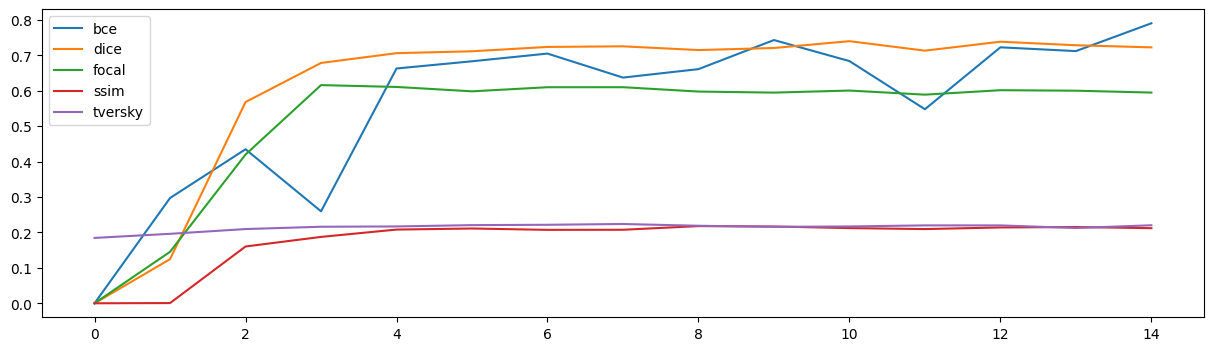

In [ ]:
plt.plot(history_bce['valid'])
plt.plot(history_dice['valid'])
plt.plot(history_focal['valid'])
plt.plot(history_ssim['valid'])
plt.plot(history_tversky['valid'])

plt.legend(NAMES_SEGNET)

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

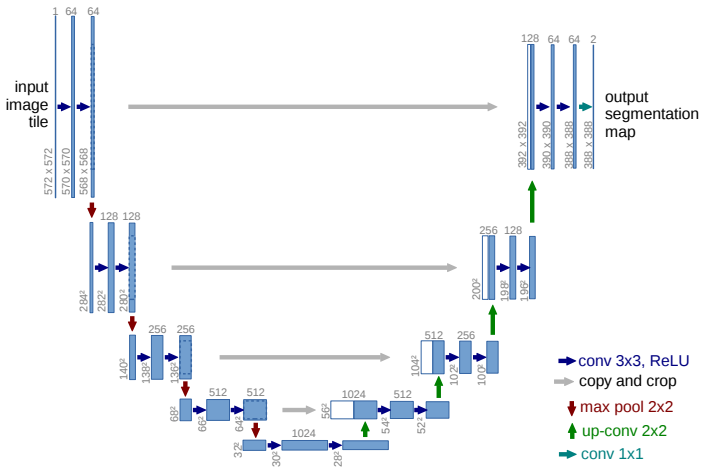

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class EncoderBlock2(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, count_conv: int):
        super().__init__()

        self.__count_conv = count_conv
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        for i in range(count_conv-1):
            conv = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                # nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
            setattr(self, f'conv_{i+2}', conv)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = x
        for i in range(self.__count_conv):
            out = getattr(self, f'conv_{i+1}')(out)

        self.pre_pool_out = out
        out = self.max_pool(out)
        return out


class DecoderBlock2(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, count_conv: int):
        super().__init__()

        self.__count_conv = count_conv
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        i = 0
        for _ in range(count_conv-1):
            i += 1
            if i == 1:
              conv = nn.Sequential(
                  nn.Conv2d(in_channels*2, in_channels, kernel_size=3, padding=1),
                  nn.ReLU(inplace=True),
              )
            else:
              conv = nn.Sequential(
                  nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
                  nn.ReLU(inplace=True),
              )
            setattr(self, f'conv_{i}', conv)

        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        setattr(self, f'conv_{i+1}', conv)

    def forward(self, x, old_x):
        out = self.upsample(x)
        out = torch.cat((out, old_x), dim=1)
        for i in range(self.__count_conv):
            out = getattr(self, f'conv_{i+1}')(out)

        return out

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()
        self.encoder = nn.Sequential(
            EncoderBlock2(3, 64, 2),
            EncoderBlock2(64, 128, 2),
            EncoderBlock2(128, 256, 2),
            EncoderBlock2(256, 512, 2),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
        )

        self.decoder = nn.Sequential(
            DecoderBlock2(512, 256, 2),
            DecoderBlock2(256, 128, 2),
            DecoderBlock2(128, 64, 2),
            DecoderBlock2(64, 32, 2),
        )
        self.last_conv = nn.Conv2d(32, n_class, 1)

    def forward(self, x):
        out = x
        for block in self.encoder:
            out = block(out)

        out = self.bottleneck(out)
        for i, block in enumerate(self.decoder):
            enc_block = self.encoder[-(i+1)]
            out = block(out, enc_block.pre_pool_out)

        out = self.last_conv(out)
        return out

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
loss = nn.BCEWithLogitsLoss()
unet_model_1 = UNet().to(device)
optimizer_1 = optim.Adam(unet_model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
history_unet_bce = train(unet_model_1, train_dataloader, valid_dataloader, loss, optimizer_1, EPOCH_COUNT, scheduler=scheduler_1, is_logit=True,)

Epoch: 1


valid: 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


IoU train: 0.0
IoU valid: 0.0
Epoch: 2


valid: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


IoU train: 0.0
IoU valid: 0.0
Epoch: 3


valid: 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]


IoU train: 0.0
IoU valid: 0.0
Epoch: 4


valid: 100%|██████████| 6/6 [00:00<00:00,  8.26it/s]


IoU train: 0.0
IoU valid: 0.0
Epoch: 5


valid: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


IoU train: 0.0
IoU valid: 0.0
Epoch: 6


valid: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]


IoU train: 0.0
IoU valid: 0.0
Epoch: 7


train:  36%|███▌      | 5/14 [00:02<00:03,  2.43it/s]


KeyboardInterrupt: 

In [ ]:
clear_cache()
unet_model_2 = UNet().to(device)
optimizer_2 = optim.Adam(unet_model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
history_unet_dice = train(unet_model_2, train_dataloader, valid_dataloader, dice_loss, optimizer_2, EPOCH_COUNT, scheduler=scheduler_2)

Epoch: 1


valid: 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]


IoU train: 0.2535138704947063
IoU valid: 0.2946602354447047
Epoch: 2


valid: 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]


IoU train: 0.31684037510837826
IoU valid: 0.3015925909082095
Epoch: 3


valid: 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]


IoU train: 0.3206049001642636
IoU valid: 0.3110560476779938
Epoch: 4


valid: 100%|██████████| 6/6 [00:00<00:00,  8.36it/s]


IoU train: 0.3177900654929025
IoU valid: 0.2957075710097949
Epoch: 5


valid: 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]


IoU train: 0.3168706202081272
IoU valid: 0.29012391219536465
Epoch: 6


valid: 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]


IoU train: 0.32057638253484455
IoU valid: 0.29850626985232037
Epoch: 7


valid: 100%|██████████| 6/6 [00:00<00:00,  8.35it/s]


IoU train: 0.31825696570532663
IoU valid: 0.29659908016522724
Epoch: 8


valid: 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]


IoU train: 0.3189358093908855
IoU valid: 0.29064691811800003
Epoch: 9


valid: 100%|██████████| 6/6 [00:00<00:00,  8.33it/s]


IoU train: 0.316386416554451
IoU valid: 0.2919759824872017
Epoch: 10


valid: 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]


IoU train: 0.3209997277174677
IoU valid: 0.2990439608693123
Epoch: 11


valid: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


IoU train: 0.3179598216499601
IoU valid: 0.2967289785544078
Epoch: 12


valid: 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]


IoU train: 0.319260336458683
IoU valid: 0.29365676641464233
Epoch: 13


valid: 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]


IoU train: 0.32137925177812576
IoU valid: 0.2939903611938159
Epoch: 14


valid: 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]


IoU train: 0.319454482623509
IoU valid: 0.2906465356548627
Epoch: 15


valid: 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

IoU train: 0.31989881076983046
IoU valid: 0.3115420589844386


In [ ]:
clear_cache()
unet_model_3 = UNet().to(device)
optimizer_3 = optim.Adam(unet_model_3.parameters(), lr=1e-3)
scheduler_3 = optim.lr_scheduler.StepLR(optimizer_3, step_size=STEP_SIZE, gamma=0.1)

In [ ]:
history_unet_focal = train(unet_model_3, train_dataloader, valid_dataloader, focal_loss, optimizer_3, EPOCH_COUNT, scheduler=scheduler_3)

Epoch: 1


valid: 100%|██████████| 6/6 [00:00<00:00,  8.33it/s]


IoU train: 0.27400935015508104
IoU valid: 0.29559529821077984
Epoch: 2


valid: 100%|██████████| 6/6 [00:00<00:00,  8.35it/s]


IoU train: 0.3197833469935826
IoU valid: 0.29285062352816266
Epoch: 3


valid: 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]


IoU train: 0.3191062829324177
IoU valid: 0.2922070821126302
Epoch: 4


valid: 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]


IoU train: 0.31839397975376676
IoU valid: 0.29124120126167935
Epoch: 5


valid: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


IoU train: 0.318696066737175
IoU valid: 0.2975093225638072
Epoch: 6


valid: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


IoU train: 0.31958325632980894
IoU valid: 0.3070399612188339
Epoch: 7


valid: 100%|██████████| 6/6 [00:00<00:00,  8.30it/s]


IoU train: 0.3166680559515953
IoU valid: 0.29694893956184387
Epoch: 8


valid: 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]


IoU train: 0.31995260076863424
IoU valid: 0.2994258254766464
Epoch: 9


valid: 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]


IoU train: 0.3174369899289949
IoU valid: 0.29053738961617154
Epoch: 10


valid: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]


IoU train: 0.3191157749720982
IoU valid: 0.30106881260871887
Epoch: 11


valid: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]


IoU train: 0.32077789306640625
IoU valid: 0.2977210382620494
Epoch: 12


valid: 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]


IoU train: 0.3207025080919266
IoU valid: 0.30223668615023297
Epoch: 13


valid: 100%|██████████| 6/6 [00:00<00:00,  8.34it/s]


IoU train: 0.3189316711255482
IoU valid: 0.3026406615972519
Epoch: 14


valid: 100%|██████████| 6/6 [00:00<00:00,  8.38it/s]


IoU train: 0.31973607199532644
IoU valid: 0.2957772562901179
Epoch: 15


valid: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

IoU train: 0.3183984309434891
IoU valid: 0.28929150849580765


In [ ]:
# save(unet_model_1, history_unet_bce, optimizer_1, bce_true, EPOCH_COUNT, 'models/unet_bce')
save(unet_model_2, history_unet_dice, optimizer_2, dice_loss, EPOCH_COUNT, 'models/unet_dice')
save(unet_model_3, history_unet_focal, optimizer_3, focal_loss, EPOCH_COUNT, 'models/unet_focal')

In [ ]:
metric_test_unet = test(unet_model_1.to(device), test_dataloader), test(unet_model_2.to(device), test_dataloader), test(unet_model_3.to(device), test_dataloader)
print('\n')
for i, name in enumerate(['bce', 'dice', 'focal']):
  print(name, f": {metric_test_unet[i]:.4}")

test: 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]



bce : 0.0
dice : 0.3689
focal : 0.351


1) Какая модель дает лучшие значения по метрике?


SegNet - 0.7345 (BCELoss)

UNet - 0.3689 (DiceLoss)

2) Какая модель дает лучшие значения по лоссам?

Loss: SegNet/UNet

BCELoss: 0.7373/0.0

DiceLoss: 0.7281/0.3689

FocalLoss: 0.6474/0.351

По всем лоссам лучшая - SegNet

3) Какая модель обучается быстрее? - SegNet

4) Сравните визуально результаты SegNet и UNet.


In [ ]:
torch.serialization.add_safe_globals([bce_loss, dice_loss, focal_loss])
*_, history_segnet_bce  = load(SegNet().to(device), None, 'models/segnet_bce')
*_, history_segnet_dice = load(SegNet().to(device), None, 'models/segnet_dice')
*_, history_segnet_focal = load(SegNet().to(device), None, 'models/segnet_focal')

*_, history_unet_dice = load(UNet().to(device), None, 'models/unet_dice')
*_, history_unet_focal = load(UNet().to(device), None, 'models/unet_focal')

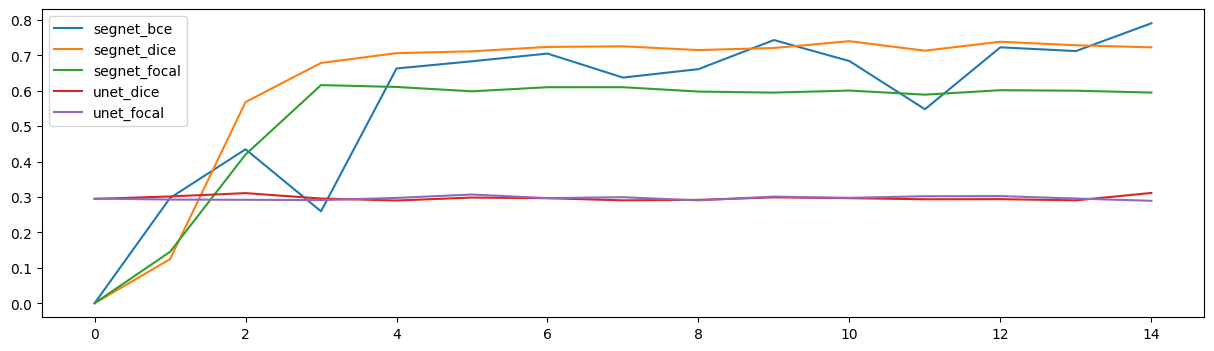

In [ ]:
plt.plot(history_segnet_bce['valid'])
plt.plot(history_segnet_dice['valid'])
plt.plot(history_segnet_focal['valid'])
plt.plot(history_unet_dice['valid'])
plt.plot(history_unet_focal['valid'])

plt.legend(['segnet_bce','segnet_dice','segnet_focal','unet_dice','unet_focal',])

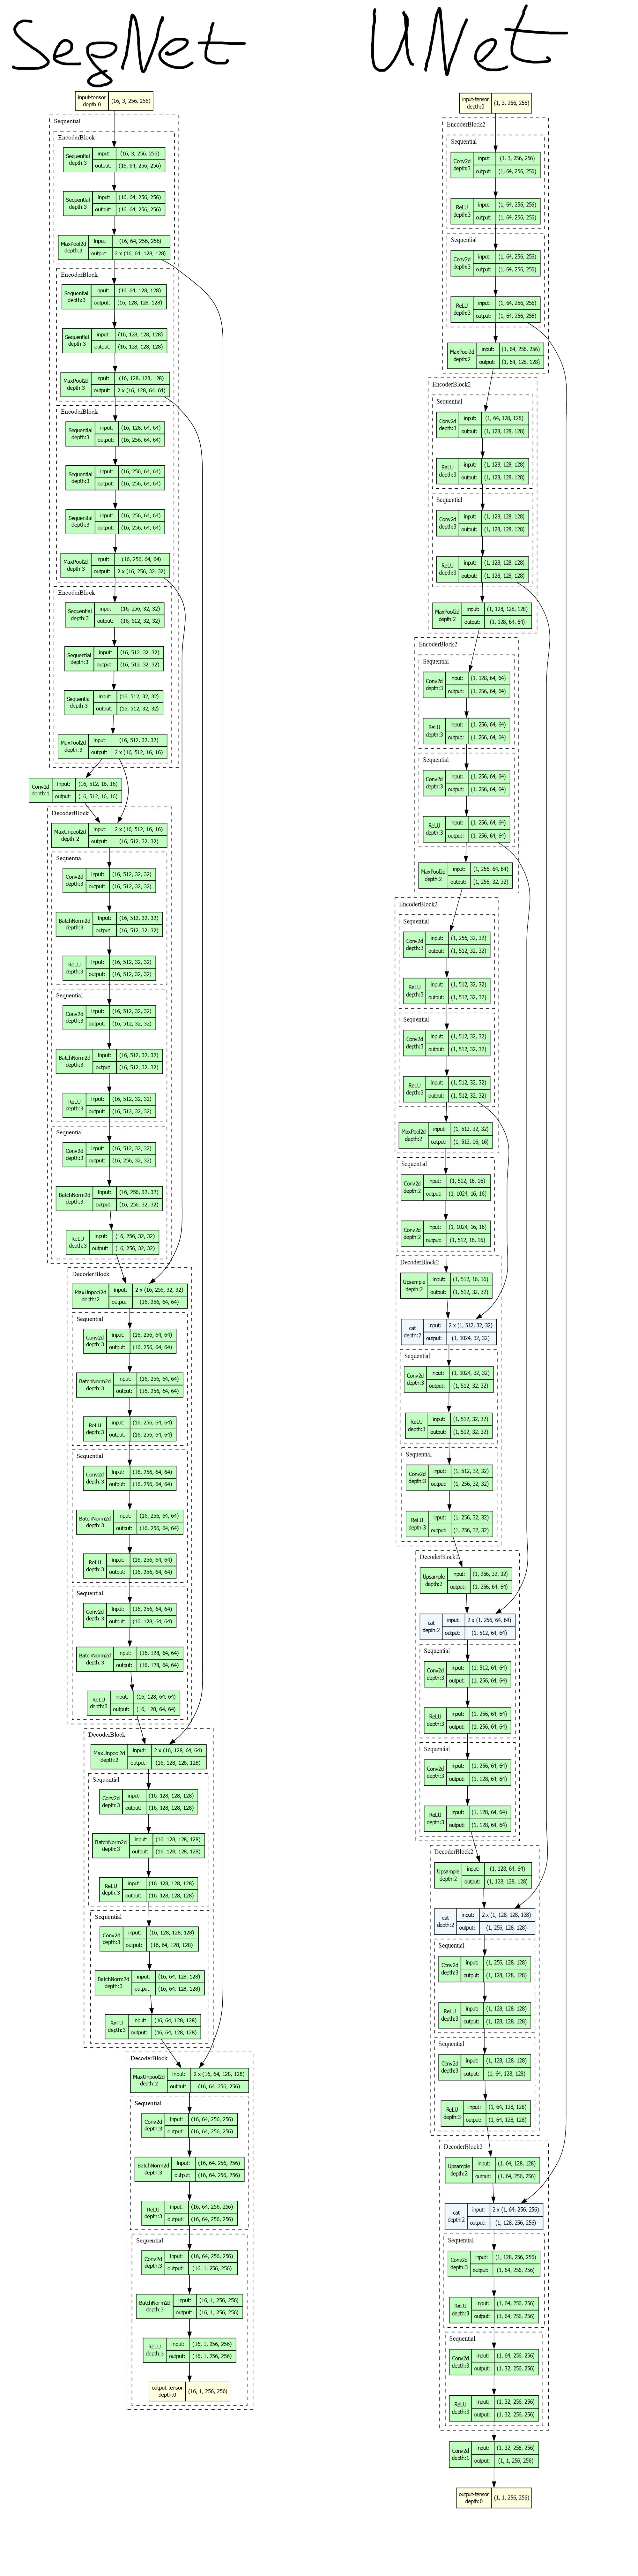